In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd

In [8]:
data = pd.read_csv('../../../../data/titanic_train.csv', index_col='PassengerId')
print(f'Данных: {data.shape[0]}')
data.head(3)

Данных: 891


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [9]:
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from keras.utils import to_categorical

class FillNa(TransformerMixin, BaseEstimator):

    def fit(self, X: pd.DataFrame, y=None):
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        return X.interpolate(method='cubic').fillna(method='pad').dropna()
        
    
    
class DropOutlet(TransformerMixin, BaseEstimator):
    """
    Удаление выбросов, основываясь на правиле 3-х сигм (только для нормального распределения)
    """
        
    def fit(self, X: pd.DataFrame, y=None):
        """
        Получаем стандартное отклонение для каждого столбца и сохраняем их        
        """
        self.std = X.std()
        self.columns = self.std.index.values
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Убираем все здачения, котоые находятся дальше 3-х стандартных отконений (сигма) от мат. ожидания случайной величины
        """
        X_cols = X[self.columns]
        return X[ (X_cols - X_cols.mean()).abs() <= 3*self.std ].dropna()

class PandasToNumpy(BaseEstimator):
    """
    Просто преобразует данные из DataFrame от pandas к матрице от numpy (ndarray)
    """
    
    def fit(self, X : pd.DataFrame = None, y=None):
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> np.ndarray:
        return X.values
    
class SparseToArray(TransformerMixin, BaseEstimator):
    """
    Класс преобразует sparse matrix в ndarray
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.toarray()

class ModifyLabelEncoder(preprocessing.LabelEncoder):
    """
    Стандартный костыль для препроцессора LabelEncoder
    """
    
    def fit(self, X, y=None):
        return super().fit(X)
    
    def transform(self, X, y=None):
        print(1)
        return super().transform(X)
    
    def fit_transform(self, X, y=None):
        return super().fit_transform(X)
    
    
class ExpandDims(TransformerMixin, BaseEstimator):
    """
    Увеличение на 1 рамерности массима в нужной оси
    """
    
    def __init__(self, axis):
        self.axis = axis
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.expand_dims(X, axis=self.axis)

In [24]:
x_data = data[data.columns[1:]].copy()
# Исключение некоторых не влияющих признаков
x_data = x_data.drop(['Ticket','Cabin','Name'],axis=1)
x_data = pd.get_dummies(x_data)

y_data = data[data.columns[0]].copy()

In [27]:
fill_na_pipe = pipeline.Pipeline([
    ('fill', FillNa()),
])

pipe_outlet = pipeline.Pipeline([
    ('fill_na', fill_na_pipe),
    ('drop_outlet', DropOutlet())
])

outletless_data_x = pipe_outlet.fit_transform(x_data)
#Синхронизация заполненных данных
outletless_data_y = y_data[ fill_na_pipe.fit_transform(y_data).index.isin(outletless_data_x.index)]
print(f'Кол-во векторов для обучения: {outletless_data_y.shape[0]}')

Кол-во векторов для обучения: 751


In [29]:
#Нормализация
pipe_x = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('norm', preprocessing.MinMaxScaler())
])

pipe_y = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('label_encoder', ModifyLabelEncoder()),
    ('expand_dims', ExpandDims(axis=1))
    #Разбитие на категории не имеет смысла, т.к у нас всего 2 категории
])

number_data_ready_x = pipe_x.fit_transform(outletless_data_x)
number_data_ready_y = pipe_y.fit_transform(outletless_data_y)
print(number_data_ready_x.shape, number_data_ready_y.shape)

(751, 10) (751, 1)


In [40]:
number_data_ready_x[:5,:], number_data_ready_y[:10]

(array([[1.        , 0.37002318, 0.33333333, 0.        , 0.04397492,
         0.        , 1.        , 0.        , 0.        , 1.        ],
        [0.        , 0.5638622 , 0.33333333, 0.        , 0.4323693 ,
         1.        , 0.        , 1.        , 0.        , 0.        ],
        [1.        , 0.41848293, 0.        , 0.        , 0.04806914,
         1.        , 0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.52751738, 0.33333333, 0.        , 0.32207838,
         1.        , 0.        , 0.        , 0.        , 1.        ],
        [1.        , 0.52751738, 0.        , 0.        , 0.04882733,
         0.        , 1.        , 0.        , 0.        , 1.        ]]),
 array([[0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1]], dtype=int64))

In [41]:
x_train = number_data_ready_x
y_train = number_data_ready_y
x_train.shape, y_train.shape

((751, 10), (751, 1))

In [42]:
from keras import layers, models, activations, optimizers, losses, metrics

In [71]:
model = models.Sequential(layers=[
    layers.Dense(10, activation='relu', input_dim=x_train.shape[1]),
    # С другой функцией активации (softmax) попросту не запускалось (не менялись значения)
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[metrics.binary_accuracy])

In [72]:
model.fit(x_train,y_train, verbose=2, epochs=50, batch_size=4)

Epoch 1/50
 - 1s - loss: 0.6448 - binary_accuracy: 0.6791
Epoch 2/50
 - 0s - loss: 0.5637 - binary_accuracy: 0.7909
Epoch 3/50
 - 0s - loss: 0.5145 - binary_accuracy: 0.7976
Epoch 4/50
 - 0s - loss: 0.4873 - binary_accuracy: 0.7936
Epoch 5/50
 - 0s - loss: 0.4724 - binary_accuracy: 0.7989
Epoch 6/50
 - 0s - loss: 0.4653 - binary_accuracy: 0.7976
Epoch 7/50
 - 0s - loss: 0.4603 - binary_accuracy: 0.8003
Epoch 8/50
 - 0s - loss: 0.4575 - binary_accuracy: 0.7976
Epoch 9/50
 - 0s - loss: 0.4542 - binary_accuracy: 0.7989
Epoch 10/50
 - 0s - loss: 0.4530 - binary_accuracy: 0.7896
Epoch 11/50
 - 0s - loss: 0.4509 - binary_accuracy: 0.7963
Epoch 12/50
 - 0s - loss: 0.4498 - binary_accuracy: 0.7909
Epoch 13/50
 - 0s - loss: 0.4486 - binary_accuracy: 0.7963
Epoch 14/50
 - 0s - loss: 0.4478 - binary_accuracy: 0.7963
Epoch 15/50
 - 0s - loss: 0.4451 - binary_accuracy: 0.8016
Epoch 16/50
 - 0s - loss: 0.4449 - binary_accuracy: 0.7923
Epoch 17/50
 - 0s - loss: 0.4435 - binary_accuracy: 0.7989
Epoch 

In [73]:
model.evaluate(x_train, y_train)

751/751 [==============================] - 0s 248us/step


[0.4112881283150532, 0.8175765648186604]

In [75]:
from keras import callbacks

In [77]:
xy_data = np.hstack( (number_data_ready_x, number_data_ready_y)).transpose((0,1))
np.random.shuffle(xy_data)
point_split = round(xy_data.shape[0] * 0.8)
train_data = xy_data[:point_split]
test_data = xy_data[point_split:]

In [86]:
x_train = train_data[:,:-1]
y_train = train_data[:,-1:]

x_test = test_data[:,:-1]
y_test = test_data[:,-1:]

In [97]:
def make_nn(input_len, output_len):
    model = models.Sequential(layers=[
        layers.Dense(10, activation=activations.relu, input_dim=input_len),
        layers.Dense(output_len, activation=activations.sigmoid)
    ])
    model.compile(optimizer='adam', loss=losses.binary_crossentropy, metrics=['accuracy'])
    return model

In [135]:
model = make_nn(x_train.shape[1], y_train.shape[1])

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=4,
    epochs=100,
    verbose=1,
    validation_data=(x_test,y_test),
    callbacks=[
        callbacks.History()
    ]
)

Train on 601 samples, validate on 150 samples
Epoch 1/100
601/601 [==============================] - 2s 3ms/step - loss: 0.5522 - acc: 0.7521 - val_loss: 0.5536 - val_acc: 0.7267
Epoch 2/100
601/601 [==============================] - 0s 793us/step - loss: 0.5204 - acc: 0.7837 - val_loss: 0.5298 - val_acc: 0.7867
Epoch 3/100
601/601 [==============================] - 0s 698us/step - loss: 0.4980 - acc: 0.7937 - val_loss: 0.5016 - val_acc: 0.8067
Epoch 4/100
601/601 [==============================] - 0s 797us/step - loss: 0.4823 - acc: 0.7887 - val_loss: 0.4834 - val_acc: 0.8000
Epoch 5/100
601/601 [==============================] - 0s 740us/step - loss: 0.4723 - acc: 0.7903 - val_loss: 0.4729 - val_acc: 0.8000
Epoch 6/100
601/601 [==============================] - 0s 742us/step - loss: 0.4658 - acc: 0.7903 - val_loss: 0.4691 - val_acc: 0.8000
Epoch 7/100
601/601 [==============================] - 0s 779us/step - loss: 0.4628 - acc: 0.7903 - val_loss: 0.4666 - val_acc: 0.8000
Epoch 8/100

Epoch 61/100
601/601 [==============================] - 0s 691us/step - loss: 0.4304 - acc: 0.8136 - val_loss: 0.4272 - val_acc: 0.8267
Epoch 62/100
601/601 [==============================] - 0s 729us/step - loss: 0.4290 - acc: 0.8037 - val_loss: 0.4278 - val_acc: 0.8267
Epoch 63/100
601/601 [==============================] - 0s 705us/step - loss: 0.4281 - acc: 0.8103 - val_loss: 0.4297 - val_acc: 0.8267
Epoch 64/100
601/601 [==============================] - 0s 760us/step - loss: 0.4287 - acc: 0.8087 - val_loss: 0.4272 - val_acc: 0.8267
Epoch 65/100
601/601 [==============================] - 0s 694us/step - loss: 0.4283 - acc: 0.8120 - val_loss: 0.4262 - val_acc: 0.8267
Epoch 66/100
601/601 [==============================] - 0s 739us/step - loss: 0.4282 - acc: 0.8120 - val_loss: 0.4262 - val_acc: 0.8267
Epoch 67/100
601/601 [==============================] - 0s 721us/step - loss: 0.4278 - acc: 0.8136 - val_loss: 0.4271 - val_acc: 0.8267
Epoch 68/100
601/601 [==========================

In [136]:
def show_learn_history(hist):
    plt.figure(0, figsize=(10,5))
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('График ошибки')
    plt.ylabel('Значение')
    plt.xlabel('Эпоха')
    plt.legend(['Ошибка (train)', 'Ошибка (test)'])

    plt.figure(1, figsize=(10,5))
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('График точности')
    plt.ylabel('Значение')
    plt.xlabel('Эпоха')
    plt.legend(['Точность (train)', 'Точность (test)'])

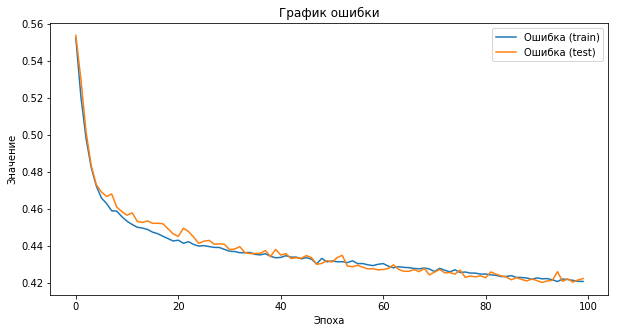

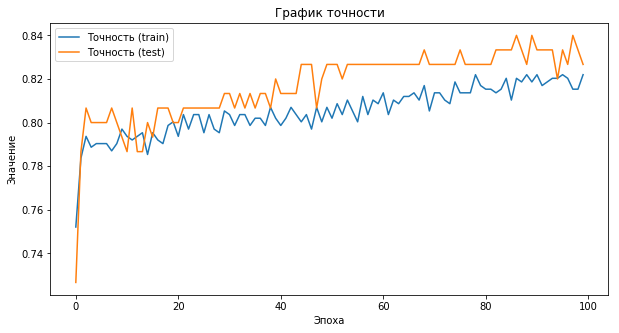

In [137]:
show_learn_history(history)

In [138]:
model = make_nn(number_data_ready_x.shape[1], number_data_ready_y.shape[1])

history = model.fit(
    x=number_data_ready_x,
    y=number_data_ready_y,
    batch_size=4,
    epochs=100,
    verbose=1,
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
    ]
)

Train on 600 samples, validate on 151 samples
Epoch 1/100
600/600 [==============================] - 2s 3ms/step - loss: 0.6363 - acc: 0.6167 - val_loss: 0.5538 - val_acc: 0.7483
Epoch 2/100
600/600 [==============================] - 0s 783us/step - loss: 0.5515 - acc: 0.7833 - val_loss: 0.4994 - val_acc: 0.8079
Epoch 3/100
600/600 [==============================] - 0s 817us/step - loss: 0.5175 - acc: 0.7867 - val_loss: 0.4715 - val_acc: 0.8146
Epoch 4/100
600/600 [==============================] - 0s 726us/step - loss: 0.5010 - acc: 0.7783 - val_loss: 0.4540 - val_acc: 0.8146
Epoch 5/100
600/600 [==============================] - 0s 738us/step - loss: 0.4911 - acc: 0.7800 - val_loss: 0.4425 - val_acc: 0.8146
Epoch 6/100
600/600 [==============================] - 0s 832us/step - loss: 0.4849 - acc: 0.7800 - val_loss: 0.4339 - val_acc: 0.8146
Epoch 7/100
600/600 [==============================] - 1s 846us/step - loss: 0.4801 - acc: 0.7817 - val_loss: 0.4277 - val_acc: 0.8212
Epoch 8/100

Epoch 61/100
600/600 [==============================] - 0s 716us/step - loss: 0.4314 - acc: 0.8083 - val_loss: 0.3593 - val_acc: 0.8543
Epoch 62/100
600/600 [==============================] - 0s 713us/step - loss: 0.4314 - acc: 0.8083 - val_loss: 0.3578 - val_acc: 0.8609
Epoch 63/100
600/600 [==============================] - 0s 721us/step - loss: 0.4314 - acc: 0.8100 - val_loss: 0.3578 - val_acc: 0.8675
Epoch 64/100
600/600 [==============================] - 0s 732us/step - loss: 0.4295 - acc: 0.8117 - val_loss: 0.3561 - val_acc: 0.8742
Epoch 65/100
600/600 [==============================] - 0s 673us/step - loss: 0.4304 - acc: 0.8050 - val_loss: 0.3566 - val_acc: 0.8609
Epoch 66/100
600/600 [==============================] - 0s 710us/step - loss: 0.4311 - acc: 0.8100 - val_loss: 0.3578 - val_acc: 0.8609
Epoch 67/100
600/600 [==============================] - 0s 762us/step - loss: 0.4296 - acc: 0.8100 - val_loss: 0.3556 - val_acc: 0.8609
Epoch 68/100
600/600 [==========================

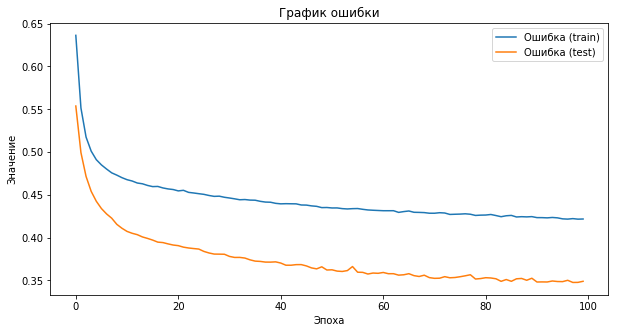

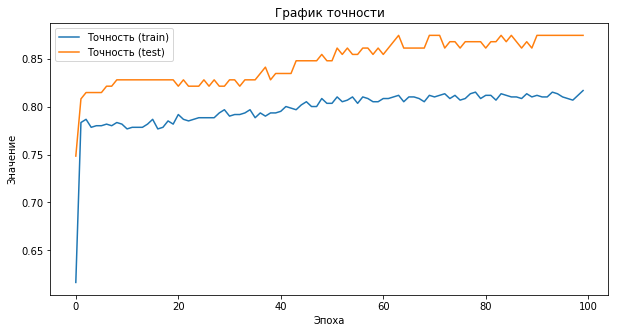

In [139]:
show_learn_history(history)

In [140]:
model = make_nn(number_data_ready_x.shape[1], number_data_ready_y.shape[1])

history = model.fit(
    x=number_data_ready_x,
    y=number_data_ready_y,
    batch_size=2,
    epochs=300,
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
        callbacks.EarlyStopping(
            monitor='val_acc',
            mode='max',
            patience=50,
            min_delta=0.01
        )
    ]
)

Train on 600 samples, validate on 151 samples
Epoch 1/300
600/600 [==============================] - 2s 4ms/step - loss: 0.6544 - acc: 0.6067 - val_loss: 0.5989 - val_acc: 0.7020
Epoch 2/300
600/600 [==============================] - 1s 2ms/step - loss: 0.5984 - acc: 0.6700 - val_loss: 0.5538 - val_acc: 0.7550
Epoch 3/300
600/600 [==============================] - 1s 2ms/step - loss: 0.5651 - acc: 0.7233 - val_loss: 0.5140 - val_acc: 0.8079
Epoch 4/300
600/600 [==============================] - 1s 1ms/step - loss: 0.5317 - acc: 0.7817 - val_loss: 0.4748 - val_acc: 0.8013
Epoch 5/300
600/600 [==============================] - 1s 1ms/step - loss: 0.5038 - acc: 0.7817 - val_loss: 0.4479 - val_acc: 0.8212
Epoch 6/300
600/600 [==============================] - 1s 2ms/step - loss: 0.4897 - acc: 0.7833 - val_loss: 0.4344 - val_acc: 0.8212
Epoch 7/300
600/600 [==============================] - 1s 1ms/step - loss: 0.4838 - acc: 0.7833 - val_loss: 0.4274 - val_acc: 0.8212
Epoch 8/300
600/600 [==

Epoch 62/300
600/600 [==============================] - 1s 1ms/step - loss: 0.4330 - acc: 0.8067 - val_loss: 0.3682 - val_acc: 0.8344
Epoch 63/300
600/600 [==============================] - 1s 1ms/step - loss: 0.4335 - acc: 0.8000 - val_loss: 0.3681 - val_acc: 0.8543
Epoch 64/300
600/600 [==============================] - 1s 1ms/step - loss: 0.4329 - acc: 0.8000 - val_loss: 0.3665 - val_acc: 0.8477
Epoch 65/300
600/600 [==============================] - 1s 1ms/step - loss: 0.4317 - acc: 0.8050 - val_loss: 0.3669 - val_acc: 0.8344
Epoch 66/300
600/600 [==============================] - 1s 1ms/step - loss: 0.4328 - acc: 0.8000 - val_loss: 0.3665 - val_acc: 0.8543
Epoch 67/300
600/600 [==============================] - 1s 2ms/step - loss: 0.4319 - acc: 0.8083 - val_loss: 0.3665 - val_acc: 0.8675
Epoch 68/300
600/600 [==============================] - 1s 1ms/step - loss: 0.4309 - acc: 0.8033 - val_loss: 0.3681 - val_acc: 0.8675
Epoch 69/300
600/600 [==============================] - 1s 1ms

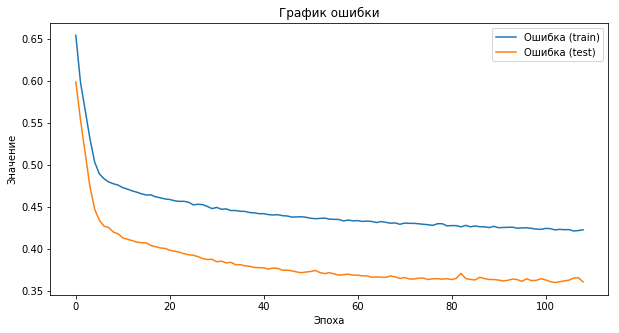

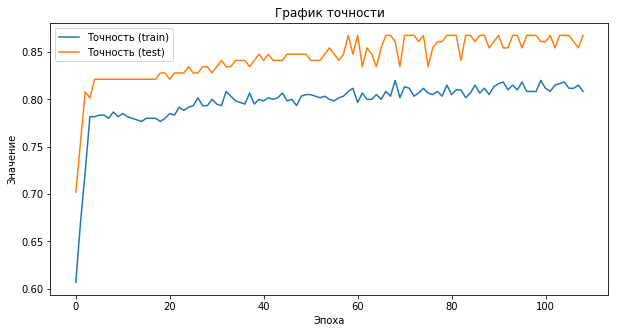

In [141]:
show_learn_history(history)

In [104]:
from pathlib import Path
from os import remove

In [110]:
file_name = 'nn_model_loss-{loss:.2f}_val_loss-{val_loss:.2f}_acc-{acc:.2f}_val_acc-{val_acc:.2f}.hdf5'

In [111]:
def make_save_points(name='save_points', file_name=file_name):
    checkpoints_dir = Path('./').joinpath('save_points')
    checkpoints_dir.mkdir(exist_ok=True)
    for item in checkpoints_dir.iterdir():
        if item.is_file():
            remove(item)
    
    return str(checkpoints_dir.joinpath(file_name))

In [158]:
print(make_save_points())
history = make_nn(x_train.shape[1], y_train.shape[1]).fit(
    x=x_train,
    y=y_train,
    batch_size=2,
    epochs=300,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        callbacks.History(),
        callbacks.EarlyStopping(
            monitor='val_acc',
            mode='max',
            patience=50,
            min_delta=0.01
        ),
        callbacks.ModelCheckpoint(
            make_save_points(file_name=file_name),
            monitor='val_acc',
            save_best_only=True,
            period=5,
            mode='max'
        )
    ]
)

save_points\nn_model_loss-{loss:.2f}_val_loss-{val_loss:.2f}_acc-{acc:.2f}_val_acc-{val_acc:.2f}.hdf5
Train on 480 samples, validate on 121 samples
Epoch 1/300
480/480 [==============================] - 2s 3ms/step - loss: 0.6061 - acc: 0.6333 - val_loss: 0.5540 - val_acc: 0.6860
Epoch 2/300
480/480 [==============================] - 0s 999us/step - loss: 0.5474 - acc: 0.7333 - val_loss: 0.5202 - val_acc: 0.7769
Epoch 3/300
480/480 [==============================] - 0s 927us/step - loss: 0.5134 - acc: 0.7812 - val_loss: 0.4997 - val_acc: 0.7769
Epoch 4/300
480/480 [==============================] - 1s 1ms/step - loss: 0.4889 - acc: 0.7875 - val_loss: 0.4825 - val_acc: 0.7769
Epoch 5/300
480/480 [==============================] - 0s 1ms/step - loss: 0.4759 - acc: 0.7896 - val_loss: 0.4828 - val_acc: 0.7769
Epoch 6/300
480/480 [==============================] - 0s 995us/step - loss: 0.4706 - acc: 0.7958 - val_loss: 0.4783 - val_acc: 0.7769
Epoch 7/300
480/480 [===========================

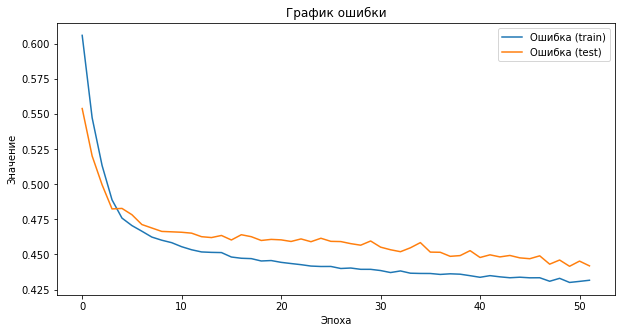

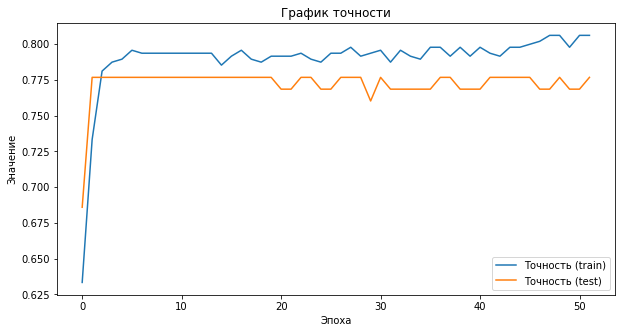

In [159]:
show_learn_history(history)

In [145]:
from keras.models import load_model

loaded_model = load_model('./save_points/nn_model_loss-0.44_val_loss-0.46_acc-0.80_val_acc-0.79.hdf5')
print(f'Точность предсказания на тренировочных данных {loaded_model.evaluate(x_train, y_train)[1]}')
print(f'Точность предсказания на тестовых данных {loaded_model.evaluate(x_test, y_test)[1]}')
predict = loaded_model.predict_classes(x_test)
predict

601/601 [==============================] - 1s 1ms/step
Точность предсказания на тренировочных данных 0.8003327776112295
150/150 [==============================] - 0s 73us/step
Точность предсказания на тестовых данных 0.7999999984105428


array([[1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
    

In [146]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf(xx, yy)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

(751,)
(751, 2)


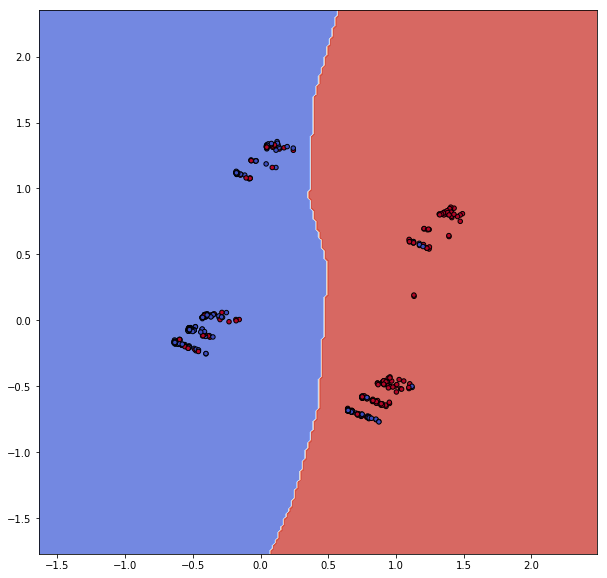

In [153]:
from sklearn.decomposition import PCA
pipe_y_mini = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('label_encoder', ModifyLabelEncoder()),
])


Y = pipe_y_mini.fit_transform(outletless_data_y)
X = number_data_ready_x

print(Y.shape)
pca = PCA(n_components=2)

_X = pca.fit_transform(X)
print(_X.shape)

clf_predict = lambda xx, yy: model.predict_classes(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))

X0, X1 = _X[:, 0], _X[:, 1]
xx, yy = make_meshgrid(X0, X1)

clf_predict(xx, yy)

fig, ax = plt.subplots(1,1, figsize=(10, 10))
plot_contours(ax, clf_predict, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=Y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

Даже какие-то адекватные выводы сложно сделать. Данные после удаления выбросов и заполнения значений приобрели чётко выраженные кластеры ? На самом деле всё делится по какому-нибудь Pclass'у или же при выполнении работы была произведена ошибка и я пытался найти не выживаемость, а что-то другое ?

0